In [12]:
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import math
import pandas as pd
import copy

# константы генетического алгоритма
POPULATION_SIZE = 300   # количество индивидуумов в популяции
P_CROSSOVER = 0.9       # вероятность скрещивания
P_MUTATION = 0.9        # вероятность мутации индивидуума
MAX_GENERATIONS = 20    # максимальное количество поколений

In [13]:
HISTORY = []
HISTORY2 = []

LAMDA0 = 0.00001
K = 50
v = 100
Time = 100
# (Т_огр)T0 = T_lim
T_lim = 300

e_1 = 4
e_1i = 2
e_tr = 6
e_tri = 2

{(0, 1): Text(0.4557862951892642, -0.08698829634636623, '1000'),
 (0, 2): Text(0.5554789816132112, -0.4570236401657979, '200'),
 (1, 3): Text(-0.08442631357046787, 0.22182679492976368, '200'),
 (2, 3): Text(0.015266372853479093, -0.14820854888966797, '100'),
 (2, 4): Text(0.037225829942355404, 0.2174479481456541, '50'),
 (3, 5): Text(-0.3803056387927042, 0.285084880211497, '100'),
 (3, 6): Text(-0.07093056079435123, -0.5644570052871438, '100'),
 (4, 6): Text(-0.04897110370547492, -0.19880050825182177, '200'),
 (4, 7): Text(-0.7671518055400492, -0.28937544687334504, '50'),
 (5, 8): Text(-0.10944860913793035, 0.9339973534878558, '50'),
 (6, 8): Text(0.1999264688604226, 0.08445546798921488, '50'),
 (7, 8): Text(-0.5182542329741517, -0.006119470632308388, '50')}

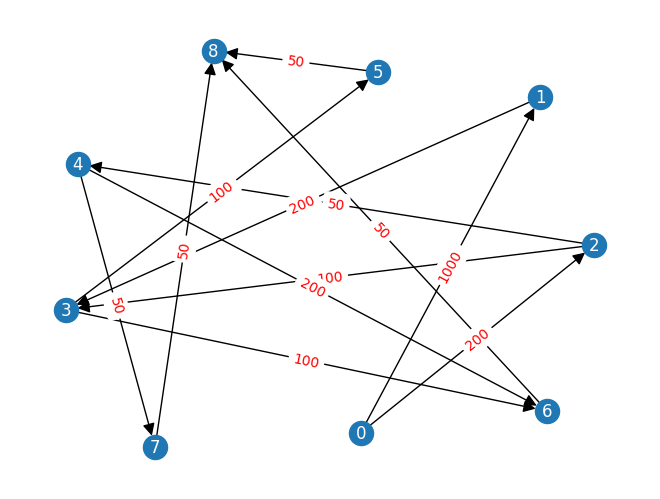

In [14]:
martx = [
[0, 1000, 200, 0, 0, 0, 0, 0, 0], 
[0, 0, 0, 200, 0, 0, 0, 0, 0], 
[0, 0, 0, 100, 50, 0, 0, 0, 0], 
[0, 0, 0, 0, 0, 100, 100, 0, 0], 
[0, 0, 0, 0, 0, 0, 200, 50, 0], 
[0, 0, 0, 0, 0, 0, 0, 0, 50], 
[0, 0, 0, 0, 0, 0, 0, 0, 50], 
[0, 0, 0, 0, 0, 0, 0, 0, 50], 
[0, 0, 0, 0, 0, 0, 0, 0, 0], 
] 

tasks_graph = nx.DiGraph(np.array(martx))
task_weight = [100, 500, 500, 300, 100, 300, 200, 100, 100]

options = {
    'width': 1,
    'arrowstyle': '-|>',
    'arrowsize': 18,
}

pos = nx.spring_layout(tasks_graph, k=150,seed=1254)
nx.draw(tasks_graph, pos, with_labels=True, font_color='white', **options)
nx.draw_networkx_edge_labels(tasks_graph, pos, {(x, y): z['weight'] for (x, y, z) in nx.to_edgelist(tasks_graph)},font_color='red')

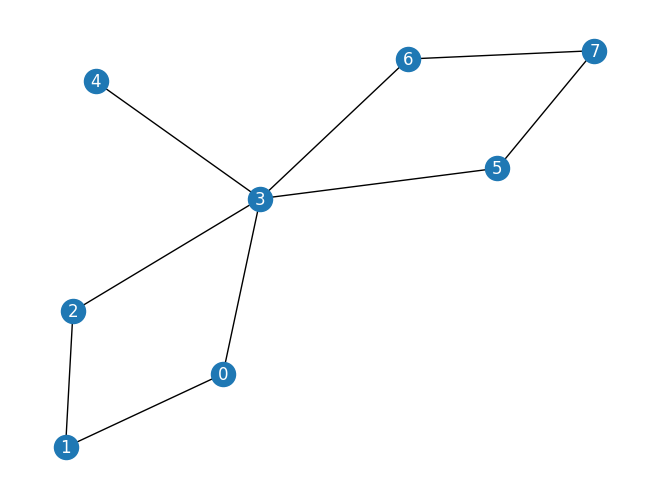

In [15]:
martx = [
    [0, 1, 0, 1, 0, 0, 0, 0], 
    [1, 0, 1, 0, 0, 0, 0, 0], 
    [0, 1, 0, 1, 0, 0, 0, 0], 
    [1, 0, 1, 0, 1, 1, 1, 0], 
    [0, 0, 0, 1, 0, 0, 0, 0], 
    [0, 0, 0, 1, 0, 0, 0, 1], 
    [0, 0, 0, 1, 0, 0, 0, 1], 
    [0, 0, 0, 0, 0, 1, 1, 0], 
]

network_graph = nx.Graph(np.array(martx))

net_power = [100,100,200,500,300,300,300,1000]
emax = [6, 6 , 6, 10, 6, 6, 8 ,6]
eidle = [5, 2, 2, 2, 4, 2, 2, 5]

epsi = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

pos = nx.spring_layout(network_graph, seed=100)
nx.draw(network_graph, pos, with_labels=True, font_color='white')

In [16]:
def FLamda(D):
    return LAMDA0 * 2 ** (K * D / 10)


def P(lamda):
    return math.exp(-lamda * Time)


def F(p, epsi):
    res = 1
    for i in range(len(p)):
        if p[i] > 0:
            res *= p[i] ** epsi[i]
    return res

In [17]:
class Individual():
    def __init__(self, *args):
        super().__init__(*args)
        self.f = 0
        self.E = 100000000
        self.W = []
        self.T_task = 0
        self.T_NET = 0
        self.distribution = []
        self.short_path = []

    def __str__(self):
        return f'''f: {self.f}\n 
Распределение: {self.distribution}, \n
Нагруженность на узлы: {self.W}, \n
Производительность узлов: {net_power}\n
трудоемкость задач: {task_weight}\n
D {self.D}\n
T_task {self.T_task}\n
T_NET {self.T_NET} \n
short_path {self.short_path}\n
# Сколько каждый узел должен обработать задач \n
{self.v_task_to_node}\n
# Сколько каждый узел должен отправить\n
{self.v_sent_to_node} \n
# Сколько каждый узел должен принять \n
{self.v_reseive_to_node}\n
'Задача1задача2:ПутьВГрафеСети {self.paths}' \n
epsi {self.epsi}\n '''

    def node_from_distribution(self, node):
        for i in range(len(self.distribution)):
            if node in self.distribution[i]:
                return i

    def set_distribution(self, distr):
        self.distribution = distr
        self.create_paths()
        self.calculation_of_parameters()

    def create_paths(self):
        # 'Задача1задача2:ПутьВГрафеСети'
        self.paths = {}
        # Словарь путей
        # Задача:Узел
        self.relationship = {}
        for start, end, weight in nx.to_edgelist(tasks_graph):
            self.relationship[start] = self.node_from_distribution(start)
            self.relationship[end] = self.node_from_distribution(end)
            if self.relationship[start] == self.relationship[end]:
                self.paths[str(start) + str(end)] = [self.relationship[start]]
            else:
                self.paths[str(start) + str(end)] = random.choice(
                    [item for item in nx.all_shortest_paths(network_graph, self.relationship[start], self.relationship[end])])


    def calculation_of_parameters(self): 
        # Подсчет трудоемкости
        W = [0 for _ in range(len(net_power))]

        # Сколько каждый узел должен обработать задач 
        self.v_task_to_node = [0 for _ in range(len(net_power))]
        # Сколько каждый узел должен отправить
        self.v_sent_to_node = [0 for _ in range(len(net_power))]
        # Сколько каждый узел должен принять 
        self.v_reseive_to_node = [0 for _ in range(len(net_power))]

        for start, end, weight in nx.to_edgelist(tasks_graph):
            """
            start - задача начало
            end - задача конец
            weight - то сколько должено быть прередано из одной задачи в другую 
            """
            if not len(self.paths[str(start) + str(end)]) == 1:
                temp = self.paths[str(start) + str(end)].copy()
                # task_weight - нагрузка на выполнение задачи 
                #Оброботка нагрузки начала пути 
                W[temp[0]] += task_weight[start] + weight['weight']

                self.v_sent_to_node[temp[0]] += weight['weight']
                self.v_task_to_node[temp[0]] += task_weight[start]
                #Оброботка нагрузки конца пути
                W[temp[-1]] += task_weight[end] + weight['weight']

                self.v_reseive_to_node[temp[-1]] += weight['weight']
                self.v_task_to_node[temp[-1]] += task_weight[start]

                temp.pop(0)
                temp.pop(-1)
                # Оброботка нагрузки всех остальных узлов в пути
                for i in temp:
                    W[i] += 2 * weight['weight']
                    self.v_sent_to_node[i] += weight['weight']
                    self.v_reseive_to_node[i] += weight['weight']
            else:
                W[self.relationship[start]] += task_weight[start]
                self.v_task_to_node[self.relationship[start]] += task_weight[start]

                W[self.relationship[end]] += task_weight[end]
                self.v_task_to_node[self.relationship[end]] += task_weight[end]

        # Оценка времени задач изначально
        arr = ([a for a in nx.all_simple_paths(tasks_graph, 0, len(task_weight) - 1)])
        arr.sort(key=lambda x: len(x), reverse=True)
        T_task = [0 for _ in range(len(task_weight))]

        for task in arr[0]:
            T_task[task] = T_lim / len(arr[0])

        # Оценка времени задач
        for path_task in arr[1:]:
            sum_t = 0
            temp = []
            for task in path_task:
                if T_task[task] == 0:
                    temp.append(task)
                sum_t += T_task[task]
            for task in temp:
                T_task[task] = (T_lim - sum_t) / len(temp)

        T_NET = [0 for _ in range(len(net_power))]
        # Оценка времени сети
        for start, end, weight in nx.to_edgelist(tasks_graph):
            path_net = self.paths[str(start) + str(end)].copy()
            if len(path_net) == 1:
                if T_NET[path_net[-1]] == 0:
                    T_NET[path_net[-1]] = min(T_task[end], T_task[start])
                else:
                    T_NET[path_net[-1]] = min(T_task[end], T_task[start], T_NET[path_net[-1]])
            else:
                # Обработка поледего узла в пути
                if T_NET[path_net[-1]] == 0:
                    T_NET[path_net[-1]] = T_task[end]
                else:
                    T_NET[path_net[-1]] = min(T_task[end], T_NET[path_net[-1]])
                # Если будет > 1 узла то
                for node in path_net[:-1]:
                    if T_NET[node] == 0:
                        T_NET[node] = T_task[start] / len(path_net[:-1])
                    else:
                        T_NET[node] = min(T_NET[node], T_task[start] / len(path_net[:-1]))
            
            D = [0. for i in range(len(net_power))]

            for i in range(len(net_power)):
                if not T_NET[i] == 0:
                    D[i] = W[i] / (net_power[i] * T_NET[i])

        # Оценка кр. пути задач для сети
        special_t = T_lim / len(arr[0])
        for node in range(len(net_power)):
            if len(set(self.distribution[node]) & set(arr[0])) > 1:
                T_NET[node] = special_t * len(set(self.distribution[node]) & set(arr[0]))
        flag = True
        for d in D:
            if d > 1:
                flag = False

        self.epsi = [emax[i] - eidle[i] for i in range(len(emax))]

        if flag:
            lamda = [FLamda(D[i]) for i in range(len(net_power))]
            p = [P(L) for L in lamda]
            f = F(p, self.epsi)
        else:
            f = -1

        #Вычислительного устройства(ВУ). computing devices - cd
        E_cd = [0 for _ in range(len(net_power))]
        #Устройства передачи данных (УПД). data transmission devices - dtd
        E_dtd = [0 for _ in range(len(net_power))]

        for i in range(len(net_power)):
            E_cd[i] = e_1 * (self.v_task_to_node[i]/net_power[i]) + e_1 * (self.v_reseive_to_node[i]/net_power[i]) + e_1 * (self.v_sent_to_node[i]/net_power[i]) - e_1i*(T_lim - (self.v_task_to_node[i]/net_power[i]) +  (self.v_reseive_to_node[i]/net_power[i]) + (self.v_sent_to_node[i]/net_power[i]))
        for i in range(len(net_power)):
            E_dtd[i] = e_tr * (self.v_reseive_to_node[i]/v) + e_tr * (self.v_sent_to_node[i]/v) + e_tri * (T_lim - (self.v_reseive_to_node[i]+self.v_sent_to_node[i])/v)

        if flag: 
            E = sum(E_cd) + sum(E_dtd)
        else:
            E = 10000000000
        
        self.f = f
        self.E = E
        self.W = W
        self.D = D
        self.T_task = T_task
        self.T_NET = T_NET
        self.short_path = arr[0]
    
    def __eq__(self, other):
        c0 = 0
        for node in range(len(net_power)):
            c = 0
            for task in self.distribution[node]:
                if task in other.distribution[node]:
                    c +=1
            if c == len(self.distribution[node]):
                c0 +=1
        
        if c0 == len(net_power):
            return True

        return False

In [18]:
def create_random_distribution(COUNT_NODE_NET, COUNT_NODE_TASK, CONST_DISTRIBUTION={0:0}):
    random_task_distribution = [[] for _ in range(COUNT_NODE_NET)]
    temp = [x for x in range(COUNT_NODE_TASK)]
    for node, task in CONST_DISTRIBUTION.items():
        random_task_distribution[node].append(temp.pop(task))
    while not len(temp) == 0:
        random_task_distribution[random.randint(0, COUNT_NODE_NET - 1)].append(
            temp.pop(random.randint(0, len(temp) - 1)))
    return random_task_distribution

In [19]:
def individualCreator():
    temp = Individual()
    dist = create_random_distribution(len(net_power), len(task_weight))
    temp.set_distribution(dist)
    return temp

In [20]:
def random_search():
    RES_ = individualCreator()
    RES_.f = 0

    HISTORY = []

    for _ in range(100_000):
        res = individualCreator()
        if res.f > RES_.f:
            RES_ = res
        if not res.f == -1:
            HISTORY.append(res)
    return RES_, HISTORY

In [21]:
def main():
    print("T огр = ", T_lim)
    print("t = ", Time)

    HISTORY = []
    while len(HISTORY) < 4: 
        RES_ , HISTORY = random_search()

    print("---------------------------")
    print(1,' решение')
    print(HISTORY[0])
    print("---------------------------")
    print("После оптимизации")
    print(RES_)
    print("---------------------------")

In [22]:
RANDOM_SEED = 488204665213841
random.seed(RANDOM_SEED)
main()

T огр =  300
t =  100
---------------------------
1  решение
f: 0.8888475327618474
 
Распределение: [[0, 4], [6, 7], [], [5], [8, 3, 1], [], [2], []], 

Нагруженность на узлы: [2000, 1250, 400, 3850, 3950, 0, 1850, 0], 

Производительность узлов: [100, 100, 200, 500, 300, 300, 300, 1000]

трудоемкость задач: [100, 500, 500, 300, 100, 300, 200, 100, 100]

D [0.6666666666666666, 0.625, 0.1, 0.385, 0.6583333333333333, 0.0, 0.20555555555555555, 0.0]

T_task [60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0]

T_NET [30.0, 20.0, 20.0, 20.0, 180.0, 0, 30.0, 0] 

short_path [0, 1, 3, 5, 8]

# Сколько каждый узел должен обработать задач 

[900, 800, 0, 600, 2600, 0, 1100, 0]

# Сколько каждый узел должен отправить

[1450, 100, 200, 1600, 200, 0, 150, 0] 

# Сколько каждый узел должен принять 

[50, 350, 200, 1650, 1250, 0, 200, 0]

'Задача1задача2:ПутьВГрафеСети {'01': [0, 3, 4], '02': [0, 3, 6], '13': [4], '23': [6, 3, 4], '24': [6, 3, 0], '35': [4, 3], '36': [4, 3, 2, 1], '46': [0, 1], '4

In [23]:
class Individual():
    def __init__(self, *args):
        super().__init__(*args)
        self.f = 0
        self.E = 100000000
        self.W = []
        self.T_task = 0
        self.T_NET = 0
        self.distribution = []
        self.short_path = []

    def __str__(self):
        return f'''f: {self.f}\n 
Распределение: {self.distribution}, \n
Нагруженность на узлы: {self.W}, \n
Производительность узлов: {net_power}\n
трудоемкость задач: {task_weight}\n
D {self.D}\n
T_task {self.T_task}\n
T_NET {self.T_NET} \n
short_path {self.short_path}\n
# Сколько каждый узел должен обработать задач \n
{self.v_task_to_node}\n
# Сколько каждый узел должен отправить\n
{self.v_sent_to_node} \n
# Сколько каждый узел должен принять \n
{self.v_reseive_to_node}\n
'Задача1задача2:ПутьВГрафеСети {self.paths}' \n
epsi {self.epsi}
\n\n '''

    def node_from_distribution(self, node):
        for i in range(len(self.distribution)):
            if node in self.distribution[i]:
                return i

    def set_distribution(self, distr):
        self.distribution = distr
        self.create_paths()
        self.calculation_of_parameters()

    def create_paths(self):
        # 'Задача1задача2:ПутьВГрафеСети'
        self.paths = {}
        # Словарь путей
        # Задача:Узел
        self.relationship = {}
        for start, end, weight in nx.to_edgelist(tasks_graph):
            self.relationship[start] = self.node_from_distribution(start)
            self.relationship[end] = self.node_from_distribution(end)
            if self.relationship[start] == self.relationship[end]:
                self.paths[str(start) + str(end)] = [self.relationship[start]]
            else:
                self.paths[str(start) + str(end)] = random.choice(
                    [item for item in nx.all_shortest_paths(network_graph, self.relationship[start], self.relationship[end])])


    def calculation_of_parameters(self): 
        # Подсчет трудоемкости
        W = [0 for _ in range(len(net_power))]

        # Сколько каждый узел должен обработать задач 
        self.v_task_to_node = [0 for _ in range(len(net_power))]
        # Сколько каждый узел должен отправить
        self.v_sent_to_node = [0 for _ in range(len(net_power))]
        # Сколько каждый узел должен принять 
        self.v_reseive_to_node = [0 for _ in range(len(net_power))]

        for start, end, weight in nx.to_edgelist(tasks_graph):
            """
            start - задача начало
            end - задача конец
            weight - то сколько должено быть прередано из одной задачи в другую 
            """
            if not len(self.paths[str(start) + str(end)]) == 1:
                temp = self.paths[str(start) + str(end)].copy()
                # task_weight - нагрузка на выполнение задачи 
                #Оброботка нагрузки начала пути 
                W[temp[0]] += task_weight[start] + weight['weight']

                self.v_sent_to_node[temp[0]] += weight['weight']
                self.v_task_to_node[temp[0]] += task_weight[start]
                #Оброботка нагрузки конца пути
                W[temp[-1]] += task_weight[end] + weight['weight']

                self.v_reseive_to_node[temp[-1]] += weight['weight']
                self.v_task_to_node[temp[-1]] += task_weight[start]

                temp.pop(0)
                temp.pop(-1)
                # Оброботка нагрузки всех остальных узлов в пути
                for i in temp:
                    W[i] += 2 * weight['weight']
                    self.v_sent_to_node[i] += weight['weight']
                    self.v_reseive_to_node[i] += weight['weight']
            else:
                W[self.relationship[start]] += task_weight[start]
                self.v_task_to_node[self.relationship[start]] += task_weight[start]

                W[self.relationship[end]] += task_weight[end]
                self.v_task_to_node[self.relationship[end]] += task_weight[end]

        # Оценка времени задач изначально
        arr = ([a for a in nx.all_simple_paths(tasks_graph, 0, len(task_weight) - 1)])
        arr.sort(key=lambda x: len(x), reverse=True)
        T_task = [0 for _ in range(len(task_weight))]

        for task in arr[0]:
            T_task[task] = T_lim / len(arr[0])

        # Оценка времени задач
        for path_task in arr[1:]:
            sum_t = 0
            temp = []
            for task in path_task:
                if T_task[task] == 0:
                    temp.append(task)
                sum_t += T_task[task]
            for task in temp:
                T_task[task] = (T_lim - sum_t) / len(temp)

        T_NET = [0 for _ in range(len(net_power))]
        # Оценка времени сети
        for start, end, weight in nx.to_edgelist(tasks_graph):
            path_net = self.paths[str(start) + str(end)].copy()
            if len(path_net) == 1:
                if T_NET[path_net[-1]] == 0:
                    T_NET[path_net[-1]] = min(T_task[end], T_task[start])
                else:
                    T_NET[path_net[-1]] = min(T_task[end], T_task[start], T_NET[path_net[-1]])
            else:
                # Обработка поледего узла в пути
                if T_NET[path_net[-1]] == 0:
                    T_NET[path_net[-1]] = T_task[end]
                else:
                    T_NET[path_net[-1]] = min(T_task[end], T_NET[path_net[-1]])
                # Если будет > 1 узла то
                for node in path_net[:-1]:
                    if T_NET[node] == 0:
                        T_NET[node] = T_task[start] / len(path_net[:-1])
                    else:
                        T_NET[node] = min(T_NET[node], T_task[start] / len(path_net[:-1]))
            
            D = [0. for i in range(len(net_power))]

            for i in range(len(net_power)):
                if not T_NET[i] == 0:
                    D[i] = W[i] / (net_power[i] * T_NET[i])

        # Оценка кр. пути задач для сети
        special_t = T_lim / len(arr[0])
        for node in range(len(net_power)):
            if len(set(self.distribution[node]) & set(arr[0])) > 1:
                T_NET[node] = special_t * len(set(self.distribution[node]) & set(arr[0]))
        flag = True
        for d in D:
            if d > 1:
                flag = False

        self.epsi = [1 for i in range(len(emax))]

        if flag:
            lamda = [FLamda(D[i]) for i in range(len(net_power))]
            p = [P(L) for L in lamda]
            f = F(p, self.epsi)
        else:
            f = -1

        #Вычислительного устройства(ВУ). computing devices - cd
        E_cd = [0 for _ in range(len(net_power))]
        #Устройства передачи данных (УПД). data transmission devices - dtd
        E_dtd = [0 for _ in range(len(net_power))]

        for i in range(len(net_power)):
            E_cd[i] = e_1 * (self.v_task_to_node[i]/net_power[i]) + e_1 * (self.v_reseive_to_node[i]/net_power[i]) + e_1 * (self.v_sent_to_node[i]/net_power[i]) - e_1i*(T_lim - (self.v_task_to_node[i]/net_power[i]) +  (self.v_reseive_to_node[i]/net_power[i]) + (self.v_sent_to_node[i]/net_power[i]))
        for i in range(len(net_power)):
            E_dtd[i] = e_tr * (self.v_reseive_to_node[i]/v) + e_tr * (self.v_sent_to_node[i]/v) + e_tri * (T_lim - (self.v_reseive_to_node[i]+self.v_sent_to_node[i])/v)

        if flag: 
            E = sum(E_cd) + sum(E_dtd)
        else:
            E = 10000000000
        
        self.f = f
        self.E = E
        self.W = W
        self.D = D
        self.T_task = T_task
        self.T_NET = T_NET
        self.short_path = arr[0]
    
    def __eq__(self, other):
        c0 = 0
        for node in range(len(net_power)):
            c = 0
            for task in self.distribution[node]:
                if task in other.distribution[node]:
                    c +=1
            if c == len(self.distribution[node]):
                c0 +=1
        
        if c0 == len(net_power):
            return True

        return False

In [24]:
RANDOM_SEED = 488204665213841
random.seed(RANDOM_SEED)
main()

T огр =  300
t =  100
---------------------------
1  решение
f: 0.9628609001165657
 
Распределение: [[0, 4], [6, 7], [], [5], [8, 3, 1], [], [2], []], 

Нагруженность на узлы: [2000, 1250, 400, 3850, 3950, 0, 1850, 0], 

Производительность узлов: [100, 100, 200, 500, 300, 300, 300, 1000]

трудоемкость задач: [100, 500, 500, 300, 100, 300, 200, 100, 100]

D [0.6666666666666666, 0.625, 0.1, 0.385, 0.6583333333333333, 0.0, 0.20555555555555555, 0.0]

T_task [60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0, 60.0]

T_NET [30.0, 20.0, 20.0, 20.0, 180.0, 0, 30.0, 0] 

short_path [0, 1, 3, 5, 8]

# Сколько каждый узел должен обработать задач 

[900, 800, 0, 600, 2600, 0, 1100, 0]

# Сколько каждый узел должен отправить

[1450, 100, 200, 1600, 200, 0, 150, 0] 

# Сколько каждый узел должен принять 

[50, 350, 200, 1650, 1250, 0, 200, 0]

'Задача1задача2:ПутьВГрафеСети {'01': [0, 3, 4], '02': [0, 3, 6], '13': [4], '23': [6, 3, 4], '24': [6, 3, 0], '35': [4, 3], '36': [4, 3, 2, 1], '46': [0, 1], '4